# 3-D Data Visualization Notebook

The purpose of this notebook is to produce visualizations of the topoclusters/events and display them with tracks

In [31]:
# python
import numpy as np
import time as t

# physics
import uproot as ur
import awkward as ak
import vector as vec
print("Awkward version: "+str(ak.__version__))
print("Uproot version: "+str(ur.__version__))
print("Vector version: "+str(vec.__version__))

# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# import k3d

Awkward version: 1.2.2
Uproot version: 4.0.7
Vector version: 0.8.1


#### Branch Info

In [4]:
track_branches = ['trackEta_EMB1', 'trackPhi_EMB1', 'trackEta_EMB2', 'trackPhi_EMB2', 'trackEta_EMB3', 'trackPhi_EMB3',
                  'trackEta_TileBar0', 'trackPhi_TileBar0', 'trackEta_TileBar1', 'trackPhi_TileBar1',
                  'trackEta_TileBar2', 'trackPhi_TileBar2']

event_branches = ["cluster_nCells", "cluster_cell_ID", "cluster_cell_E", 'cluster_nCells', "nCluster", "eventNumber",
                  "nTrack", "nTruthPart", "truthPartPdgId", "cluster_Eta", "cluster_Phi", 'trackPt', 'trackP',
                  'trackMass', 'trackEta', 'trackPhi', 'truthPartE', 'cluster_ENG_CALIB_TOT']

geo_branches = ["cell_geo_ID", "cell_geo_eta", "cell_geo_phi", "cell_geo_rPerp", "cell_geo_sampling"]

### Functions

In [15]:
def dict_from_event_tree(_event_tree, _branches):
    ''' The purpose for this separate function is to load np arrays where possible. '''
    _special_keys = ["nCluster", "eventNumber", "nTrack", "nTruthPart"]
    _dict = dict()
    for _key in _branches:
        if _key in _special_keys:
            _branch = _event_tree.arrays(filter_name=_key)[_key].to_numpy()
        else:
            _branch = _event_tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. '''
    _dict = dict()
    for _key in _branches:
        _branch = _tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches_np(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. This always returns np arrays in the dict. '''
    _dict = dict()
    for _key in _branches:
        _branch = np.ndarray.flatten(_tree.arrays(filter_name=_key)[_key].to_numpy())
        _dict[_key] = _branch
    return _dict

def find_index_1D(_values, _unsorted):
    ''' This function is a vectorized helper function to return the 1D locations of elements in a 
    larger unsorted list (i.e. cell geo locations). It does this by repeating/tiling arrays so they
    have equal shape and then simply comparing where the elements are equal and returning a slice
    where the indices match.
    Inputs: 
        _values: the values for which to search for the locations of in _unsorted
        _unsorted: the larger un-sorted list of elements to match
    Returns:
        _locs: locations of _values in _unsorted respectively. '''
    _shape = (len(_values), len(_unsorted))
    _values_2d = np.repeat(_values, repeats=len(_unsorted)).reshape(_shape)
    _unsorted_2d = np.tile(_unsorted, reps=len(_values)).reshape(_shape)
    
    _idx_vec = np.argwhere(np.asarray(_values_2d == _unsorted_2d))
    return _idx_vec[:,1]

#### Load stuff up

In [8]:
events = '/fast_scratch/atlas_images/v01-45/pipm/'
my_event = ur.open(events+'user.angerami.24559744.OutputStream._000502.root')
my_event.keys()

['EventTree;1', 'CellGeo;1']

In [9]:
event_tree = my_event['EventTree']
geo_tree = my_event['CellGeo']

In [10]:
event_dict = dict_from_event_tree(event_tree, event_branches)

In [11]:
track_dict = dict_from_tree_branches(event_tree, track_branches)

In [13]:
geo_dict = dict_from_tree_branches_np(geo_tree, geo_branches)

#### Load up your favorite event

In [17]:
event = 22

In [23]:
ak_cluster_cell_ID = event_dict['cluster_cell_ID'][event]
cell_geo_ID = geo_dict['cell_geo_ID']

nClust = len(ak_cluster_cell_ID)

clusters = []
for j in range(nClust):
    
    # find cluster size
    _nInClust = len(ak_cluster_cell_ID[j])

    # make empty array of cluster info
    _cluster = np.zeros((_nInClust, 4))
    
    # index matching
    _indices = find_index_1D(ak_cluster_cell_ID[j].to_numpy(), cell_geo_ID)

    _cluster[:,0] = geo_dict["cell_geo_eta"][_indices]
    _cluster[:,1] = geo_dict["cell_geo_phi"][_indices]
    _cluster[:,2] = geo_dict["cell_geo_rPerp"][_indices]
    _cluster[:,3] = event_dict["cluster_cell_E"][event][j].to_numpy()
    
    clusters.append(_cluster)


### Data Conversions

In [28]:
def to_xyz(_coords):
    ''' Simple geometric conversion to xyz from eta, phi, rperp (READ: in this order)
    There is an elegant way to generalize this to be flexible for 1d or 2d, for now 2d
    Inputs: np array of shape (N, 3) where columns are [eta, phi, rPerp]
    Outputs: np array of shape (N, 3) where columns are [x,y,z] '''
    _eta = _coords[:,0]
    _phi = _coords[:,1]
    _rperp = _coords[:,2]
    _theta = 2*np.arctan( np.exp(-_eta) )
    
    cell_x = _rperp*np.cos(_phi)
    cell_y = _rperp*np.sin(_phi)
    cell_z = _rperp/np.tan(_theta)
    
    return np.column_stack([cell_x,cell_y,cell_z])

In [33]:
my_xyz = to_xyz(clusters[0][:,0:3])
print(my_xyz)

[[-1120.75975596 -1326.17643951  1130.7095868 ]
 [-1152.87043299 -1298.30531062  1130.70961579]
 [-1087.97459782 -1353.25113822  1130.70944901]
 [-1121.14647522 -1326.63339644  1079.73291865]
 [-1120.75424042 -1326.16991307  1182.75829294]
 [-1153.26822555 -1298.75266114  1079.73294259]
 [-1152.86475929 -1298.29892119  1182.75823377]
 [-1088.35041133 -1353.71726299  1079.73291483]
 [-1087.96932023 -1353.24457381  1182.75827387]
 [-1036.24041085 -1138.86410031   982.58962459]
 [-1036.23466015 -1138.85778009   988.28363569]
 [-1036.22890945 -1138.85145988   993.9871899 ]
 [-1036.22315875 -1138.84513966   999.70045197]
 [-1036.21740805 -1138.83881944  1005.42325868]
 [-1036.21165735 -1138.83249922  1011.15588458]
 [-1036.20598881 -1138.8262693   1016.89835648]
 [-1036.20015595 -1138.81985879  1022.65048822]
 [-1246.22273151 -1474.35874284  1286.36522368]
 [-1184.28731227 -1269.65466239  1130.7096153 ]
 [-1184.69624262 -1270.0918556   1079.73286457]
 [-1184.28148382 -1269.6484138   1182.75

## 3-D Visualizations

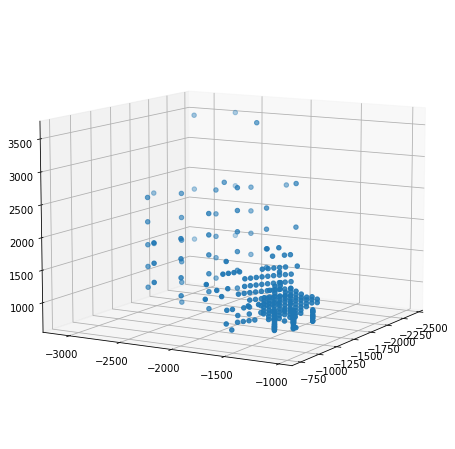

In [36]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=30)
ax.scatter(my_xyz[:,0], my_xyz[:,1], my_xyz[:,2])
plt.show()

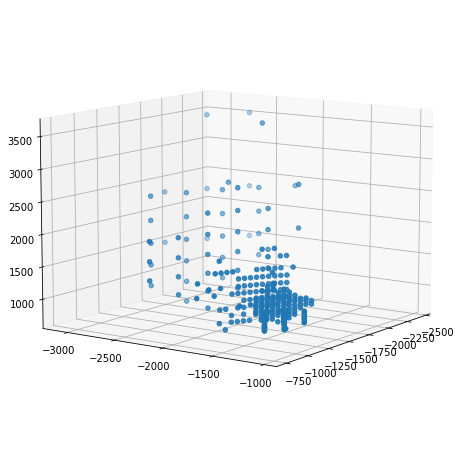

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=35)
ax.scatter(my_xyz[:,0], my_xyz[:,1], my_xyz[:,2])
plt.show()